# Competition — Network Generation

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

### Challenge Overview

Your goal is to generate a network that is as close as possible to the original real network. You do not have the original network in the explicit view, but you know some of its statistics. All statistics are in `stats.txt` file that contains a dictionary of the form
* number_nodes (number of nodes): value
* number_cc (number of connected components): value, sigma
* radius (radius of giant component): value, sigma
* diameter (diameter of giant component): value, sigma
* average_clustering (average clustering coefficient): value, sigma
* average_path_length (average path length): value, sigma
* degree_cdf (empirical CDF of degree distribution): values, probabilities

Meaning of all these sigmas is described in Evaluation section. 

You can use this code to draw CDF
```python
q_seq, p_seq = stats['degree_cdf']
    plt.plot(
        np.append(np.repeat(q_seq, 2)[1:], q_seq[-1]), 
        np.repeat(p_seq, 2)
    )
    plt.show()
```

### Evaluation Criteria

Your total score is calculated as weighted sum of 6 scores — similarities between statistics of original and generated networks. Each score takes values from the interval [0, 1], where 1 — absolute similarity with the original network. The scores are
* "KS"
    * 1 - KS_dist
    * where KS_dist is Kolmogorov-Smirnov test statistic value
* "Radius"
    * $GK(r, r', \sigma_r) = \exp{[-\frac{(r - r')^2}{2 \sigma_r^2}]}$
    * where GK is Gaussian Kernel, $r$ is a radius of the original network, $r'$ is a radius of a generated network, $\sigma_r$ is a sigma of a radius from `stats.txt` file
* "Diameter", "Av. clustering", "Av. path length", "Number of CC" are calculated by Gaussian Kernel in the same way
* "Total"
    * 1/6 KS + 1/6 Radius + 1/6 Diameter + 1/6 Av. clustering + 1/6 Av. path length + 1/6 Number of CC

All scores immediately take value 0 if a generated network has incorrect number of nodes. All scores are multiplied by 100 on the leaderboard.

**Baselines**

Baselines are calculated by the following algorithm:
1. Generate a random degree sequence using Inverse Transform Sampling
2. Generate a valid graph by Configuration Model
3. Calculate total score
4. Repeat 1-3 steps 1000 times and accumulate a set of total scores

* Baseline for grade 4: beat a mean total score
* Baseline for grade 6: beat a mean + 3*sigma total score
* Baseline for grade 8: beat a maximum total score

Calculated baselines are in the leaderboard.

### Submission Guidelines

Submit a txt file with a list of edges without self-loops and parallels. The correct form is
```
1 2
1 3
3 2
```
and so on.

In [2]:
import json
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

In [3]:
#with open('/content/drive/MyDrive/stats.txt') as f:
with open('stats.txt') as f:
  s = f.read()
  json_acceptable_string = s.replace("'", "\"")
  stats = json.loads(json_acceptable_string)
  number_nodes = stats['number_nodes']  # number of nodes
  print(f'number_nodes(value):{number_nodes}')
  number_cc_value, number_cc_sigma = stats['number_cc']  # number of connected components
  print(f'number_cc(value, sigma):{number_cc_value, number_cc_sigma}')
  radius_value, radius_sigma = stats['radius']  # radius of giant component
  print(f'radius(value, sigma):{radius_value, radius_sigma}')
  diameter_value, diameter_sigma = stats['diameter']  # diameter of giant component
  print(f'diameter(value, sigma):{diameter_value, diameter_sigma}')
  average_clustering_value, average_clustering_sigma = stats['average_clustering']  # average clustering coefficient
  print(f'average_clustering(value, sigma):{average_clustering_value, average_clustering_sigma}')
  average_path_length_value, average_path_length_sigma = stats['average_path_length']  # average path length
  print(f'average_path_length(value, sigma):{average_path_length_value, average_path_length_sigma}')
  degree_cdf_values, degree_cdf_probabilities = stats['degree_cdf']  # empirical CDF of degree distribution
  print(f'degree_cdf(values, probabilities):')
  for i in range(len(degree_cdf_values)):
    print(f'{degree_cdf_values[i]} : {degree_cdf_probabilities[i]}')

number_nodes(value):1882
number_cc(value, sigma):(168, 32)
radius(value, sigma):(15, 2)
diameter(value, sigma):(28, 4)
average_clustering(value, sigma):(0.005066798238955518, 0.001)
average_path_length(value, sigma):(11.748410823170731, 2)
degree_cdf(values, probabilities):
0 : 0.0
1 : 0.6902231668437833
2 : 0.8517534537725824
3 : 0.9086078639744952
4 : 0.9378320935175345
5 : 0.9516471838469713
6 : 0.9654622741764081
7 : 0.9723698193411264
8 : 0.9776833156216791
9 : 0.9808714133900106
10 : 0.9845908607863975
11 : 0.9888416578108395
12 : 0.9893730074388948
13 : 0.9925611052072264
14 : 0.9936238044633369
15 : 0.9952178533475027
16 : 0.9957492029755579
17 : 0.9968119022316685
19 : 0.997874601487779
21 : 0.9989373007438895
24 : 0.9994686503719448
46 : 1.0


In [4]:
def draw_cdf(degree_cdf):
  q_seq, p_seq = degree_cdf
  plt.plot(
      np.append(np.repeat(q_seq, 2)[1:], q_seq[-1]), 
      np.repeat(p_seq, 2)
      )
  plt.show()

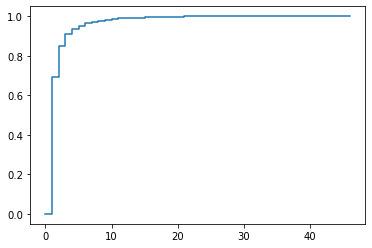

In [5]:
draw_cdf((degree_cdf_values, degree_cdf_probabilities))

In [6]:
def get_graph_stats(graph):
  d = {}
  number_nodes = graph.number_of_nodes()  # number of nodes
  d['number_nodes'] = number_nodes
  #print(f'number_nodes: value:\n{number_nodes}')

  number_cc = nx.number_connected_components(graph)  # number of connected components
  d['number_cc'] = number_cc
  #print(f'number_cc: value, sigma:\n{number_cc}')

  Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
  giant_component = graph.subgraph(Gcc[0])
  #print(f'giant component = {giant_component}')

  radius = nx.radius(giant_component)  # radius of giant component
  d['radius'] = radius
  #print(f'radius: value, sigma:\n{radius}')

  diameter = nx.diameter(giant_component)  # diameter of giant component
  d['diameter'] = diameter
  #print(f'diameter: value, sigma:\n{diameter}')

  average_clustering = nx.average_clustering(graph)  # average clustering coefficient
  d['average_clustering'] = average_clustering
  #print(f'average_clustering: value, sigma:\n{average_clustering}')

  average_path_length = nx.average_shortest_path_length(giant_component)  # average path length
  #average_path_length = np.mean(average_pathes)
  d['average_path_length'] = average_path_length
  
  return d

In [7]:
def print_degree_distribution(graph, degree_sequence):
  degree_seq = np.array([degree for (node, degree) in graph.degree])
  unique, counts = np.unique(degree_seq, return_counts=True)
  #print(np.asarray((unique, counts)).T)
  for num, i in enumerate(list(np.asarray((unique, counts)).T)):
    print(f'{i[0]}: {i[1]}, target={int(degree_sequence[num])}, diff={int(degree_sequence[num]) - i[1]}')
  print()
  print(f'{len(degree_seq)}, target={int(sum(degree_sequence))}, diff={int(sum(degree_sequence)) - len(degree_seq)}')

In [8]:
def get_gk(stat_orig, stat_gen, stat_sigma):
  gk = (stat_orig - stat_gen) ** 2
  gk /= 2 * stat_sigma ** 2
  gk = np.exp(-gk)
  return gk

In [9]:
def get_part_score(graph, number_cc_value, number_cc_sigma, radius_value, radius_sigma, diameter_value, diameter_sigma,
                   average_clustering_value, average_clustering_sigma, average_path_length_value, average_path_length_sigma):
  generated_stats = get_graph_stats(graph)
  
  number_cc_score = get_gk(number_cc_value, generated_stats['number_cc'], number_cc_sigma) * 100
  print(f'number_cc_score={number_cc_score}')
  radius_score = get_gk(radius_value, generated_stats['radius'], radius_sigma) * 100
  print(f'radius_score={radius_score}')
  diameter_score = get_gk(diameter_value, generated_stats['diameter'], diameter_sigma) * 100
  print(f'diameter_score={diameter_score}')
  average_clustering_score = get_gk(average_clustering_value, generated_stats['average_clustering'], average_clustering_sigma) * 100
  print(f'average_clustering_score={average_clustering_score}')
  average_path_length_score = get_gk(average_path_length_value, generated_stats['average_path_length'], average_path_length_sigma) * 100
  print(f'average_path_length_score={average_path_length_score}')
  
  score   = number_cc_score + radius_score + diameter_score + average_clustering_score + average_path_length_score

  return score

In [10]:
def get_score(graph, part_score, target_degree_sequence):
  degree_seq = [degree for (node, degree) in graph.degree]
  KSTest = ks_2samp(degree_seq, target_degree_sequence)
  ks = (1 - KSTest.statistic) * 100
  print(f'ks={ks}')
  total_score = (part_score + ks) / 6
  return total_score

In [11]:
def generate_degree_sequence_by_cdf(degree_cdf_values, degree_cdf_probabilities, number_nodes):
  degree_sequence = []
  degrees = []
  n = len(degree_cdf_values)
  cdf_cnt = [0] * n
  cnt = [0] * n

  for i in range(n):
    cdf_cnt[i] = degree_cdf_probabilities[i] * number_nodes

  for j in range(1, n):
    cnt[j] = cdf_cnt[j] - cdf_cnt[j - 1]
    print(f'{degree_cdf_values[j]} - {cnt[j]}')
    degree_sequence.append(cnt[j])

  for k in range(n):
    for m in range(int(cnt[k])):
      degrees.append(degree_cdf_values[k])
  
  return degree_sequence, degrees

In [12]:
n = len(degree_cdf_values)
total_sum = 0
cdf_cnt = [0] * n
cnt = [0] * n
for i in range(n):
  cdf_cnt[i] = degree_cdf_probabilities[i] * number_nodes
  #print(f'{degree_cdf_values[i]} : {degree_cdf_probabilities[i]} - {cdf_cnt[i]}')
#print()
print(f'{degree_cdf_values[0]}  - {cnt[0]}')
for j in range(1, n):
  cnt[j] = cdf_cnt[j] - cdf_cnt[j - 1]
  print(f'{degree_cdf_values[j]} - {cnt[j]}')
  total_sum += degree_cdf_values[j] * cnt[j]
print(f'total_edges: {total_sum / 2}')

0  - 0
1 - 1299.0
2 - 304.0
3 - 107.0
4 - 55.0
5 - 26.0
6 - 26.0
7 - 13.0
8 - 10.0
9 - 6.0
10 - 7.0
11 - 8.0
12 - 1.0
13 - 6.0
14 - 2.0
15 - 3.0
16 - 1.0
17 - 2.0
19 - 2.0
21 - 2.0
24 - 1.0
46 - 1.0
total_edges: 1740.0


In [13]:
degree_sequence, degrees = generate_degree_sequence_by_cdf(degree_cdf_values, degree_cdf_probabilities, number_nodes)
#np.random.shuffle(degree_sequence)
len(degree_sequence)

1 - 1299.0
2 - 304.0
3 - 107.0
4 - 55.0
5 - 26.0
6 - 26.0
7 - 13.0
8 - 10.0
9 - 6.0
10 - 7.0
11 - 8.0
12 - 1.0
13 - 6.0
14 - 2.0
15 - 3.0
16 - 1.0
17 - 2.0
19 - 2.0
21 - 2.0
24 - 1.0
46 - 1.0


21

In [14]:
# Create giant component
# Radius = 15, diameter = 28
G1 = nx.path_graph(30)
G1.add_edge(0, 29)
G2 = nx.path_graph(29)
G = nx.disjoint_union(G1, G2)
G.add_edge(0, 30)
G.add_edge(0, 58)
G3 = nx.path_graph(13)
G = nx.disjoint_union(G, G3)
G.add_edge(8, 59)
G.add_edge(37, 71)
G4 = nx.path_graph(13)
G = nx.disjoint_union(G, G4)
G.add_edge(22, 72)
G.add_edge(51, 84)

get_graph_stats(G)

{'number_nodes': 85,
 'number_cc': 1,
 'radius': 15,
 'diameter': 28,
 'average_clustering': 0.0,
 'average_path_length': 12.456022408963586}

In [15]:
# Average path 11.748410823170731

#G.add_edge(4, 33)
#!G.add_edge(24, 53)
#G.add_edge(3, 35) # 11.728851540616246 28 15
G.add_edge(4, 35) # 11.743697478991596 28 15
#G.add_edge(8, 26)

get_graph_stats(G)

{'number_nodes': 85,
 'number_cc': 1,
 'radius': 15,
 'diameter': 28,
 'average_clustering': 0.0,
 'average_path_length': 11.743697478991596}

{'number_nodes': 85, 'number_cc': 1, 'radius': 15, 'diameter': 28, 'average_clustering': 0.0, 'average_path_length': 11.743697478991596}


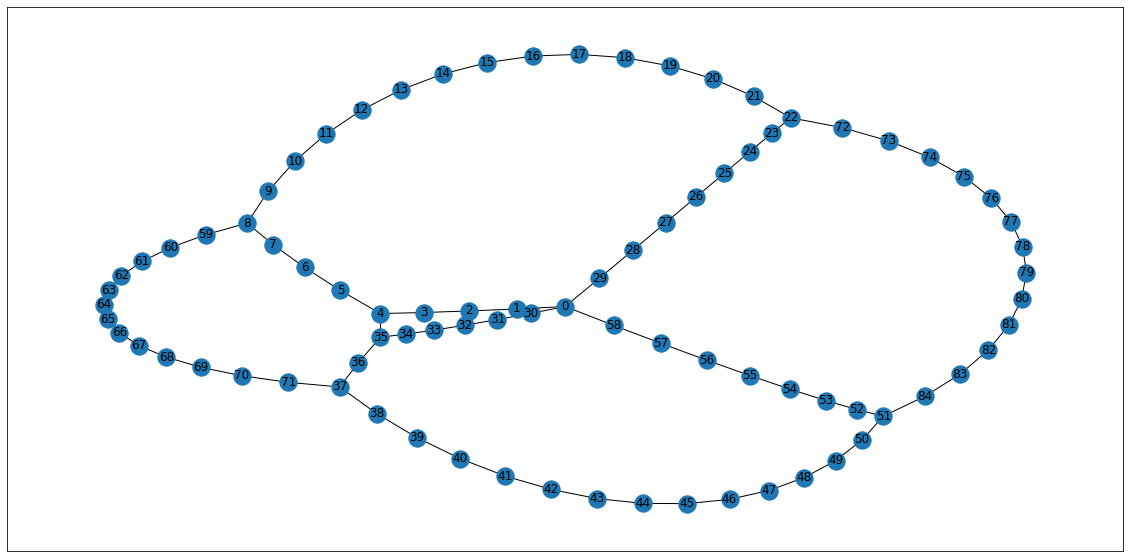

In [16]:
plt.figure(figsize=(20, 10))
print(get_graph_stats(G))
nx.draw_networkx(G, pos=nx.spectral_layout(G))

In [17]:
print_degree_distribution(G, degree_sequence)

2: 78, target=1299, diff=1221
3: 6, target=304, diff=298
4: 1, target=107, diff=106

85, target=1882, diff=1797


In [18]:
# Other components
# non connected star graphs
# number of connected components 168

S46 = nx.star_graph(46)
G = nx.disjoint_union(G, S46)

S24 = nx.star_graph(24)
G = nx.disjoint_union(G, S24)

for _ in range(2):
  S21 = nx.star_graph(21)
  G = nx.disjoint_union(G, S21)
  S19 = nx.star_graph(19)
  G = nx.disjoint_union(G, S19)
  S17 = nx.star_graph(17)
  G = nx.disjoint_union(G, S17)
  S14 = nx.star_graph(14)
  G = nx.disjoint_union(G, S14)

S16 = nx.star_graph(16)
G = nx.disjoint_union(G, S16)
S12 = nx.star_graph(12)
G = nx.disjoint_union(G, S12)

for _ in range(3):
  S15 = nx.star_graph(15)
  G = nx.disjoint_union(G, S15)

for _ in range(6):
  S13 = nx.star_graph(13)
  G = nx.disjoint_union(G, S13)
  S9 = nx.star_graph(9)
  G = nx.disjoint_union(G, S9)

for _ in range(8):
  S11 = nx.star_graph(11)
  G = nx.disjoint_union(G, S11)

for _ in range(7):
  S10 = nx.star_graph(10)
  G = nx.disjoint_union(G, S10)

for _ in range(10):
  S8 = nx.star_graph(8)
  G = nx.disjoint_union(G, S8)

for _ in range(13):
  S7 = nx.star_graph(7)
  G = nx.disjoint_union(G, S7)

for _ in range(26):
  S5 = nx.star_graph(5)
  G = nx.disjoint_union(G, S5)

for _ in range(26):
  S6 = nx.star_graph(6)
  G = nx.disjoint_union(G, S6)

for _ in range(54):
  S4 = nx.star_graph(4)
  G = nx.disjoint_union(G, S4)


get_graph_stats(G)

{'number_nodes': 1504,
 'number_cc': 172,
 'radius': 15,
 'diameter': 28,
 'average_clustering': 0.0,
 'average_path_length': 11.743697478991596}

In [19]:
print_degree_distribution(G, degree_sequence)

1: 1248, target=1299, diff=51
2: 78, target=304, diff=226
3: 6, target=107, diff=101
4: 55, target=55, diff=0
5: 26, target=26, diff=0
6: 26, target=26, diff=0
7: 13, target=13, diff=0
8: 10, target=10, diff=0
9: 6, target=6, diff=0
10: 7, target=7, diff=0
11: 8, target=8, diff=0
12: 1, target=1, diff=0
13: 6, target=6, diff=0
14: 2, target=2, diff=0
15: 3, target=3, diff=0
16: 1, target=1, diff=0
17: 2, target=2, diff=0
19: 2, target=2, diff=0
21: 2, target=2, diff=0
24: 1, target=1, diff=0
46: 1, target=1, diff=0

1504, target=1882, diff=378


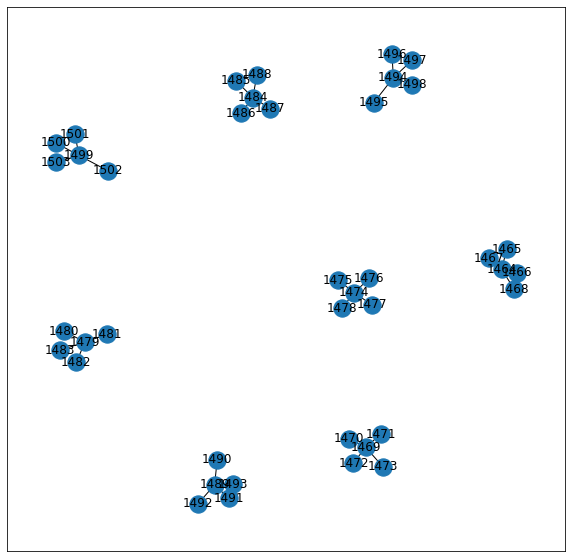

In [20]:
D = G.subgraph(list(range(1504))[1464:]) 
plt.figure(figsize=(10, 10))
nx.draw_networkx(D)
plt.show()

In [21]:
# -4(cc) 
# -8(1) +8(2) +8(3) +8(n)

G.add_nodes_from([1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511])

G.add_edge(1468, 1504)
G.add_edge(1468, 1505)
G.add_edge(1473, 1504)
G.add_edge(1473, 1505)

G.add_edge(1478, 1506)
G.add_edge(1478, 1507)
G.add_edge(1493, 1506)
G.add_edge(1493, 1507)

G.add_edge(1503, 1508)
G.add_edge(1503, 1509)
G.add_edge(1488, 1508)
G.add_edge(1488, 1509)

G.add_edge(1483, 1510)
G.add_edge(1483, 1511)
G.add_edge(1498, 1510)
G.add_edge(1498, 1511)

get_graph_stats(G)

{'number_nodes': 1512,
 'number_cc': 168,
 'radius': 15,
 'diameter': 28,
 'average_clustering': 0.0,
 'average_path_length': 11.743697478991596}

In [22]:
print_degree_distribution(G, degree_sequence)

1: 1240, target=1299, diff=59
2: 86, target=304, diff=218
3: 14, target=107, diff=93
4: 55, target=55, diff=0
5: 26, target=26, diff=0
6: 26, target=26, diff=0
7: 13, target=13, diff=0
8: 10, target=10, diff=0
9: 6, target=6, diff=0
10: 7, target=7, diff=0
11: 8, target=8, diff=0
12: 1, target=1, diff=0
13: 6, target=6, diff=0
14: 2, target=2, diff=0
15: 3, target=3, diff=0
16: 1, target=1, diff=0
17: 2, target=2, diff=0
19: 2, target=2, diff=0
21: 2, target=2, diff=0
24: 1, target=1, diff=0
46: 1, target=1, diff=0

1512, target=1882, diff=370


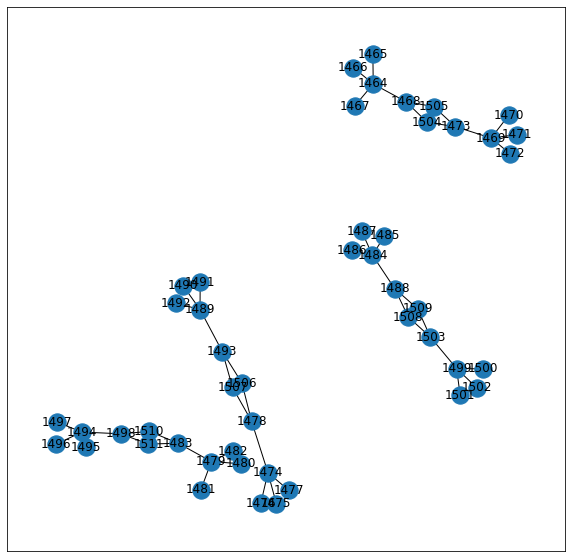

In [23]:
D = G.subgraph(list(range(1513))[1464:]) 
plt.figure(figsize=(10, 10))
nx.draw_networkx(D)
plt.show()

28


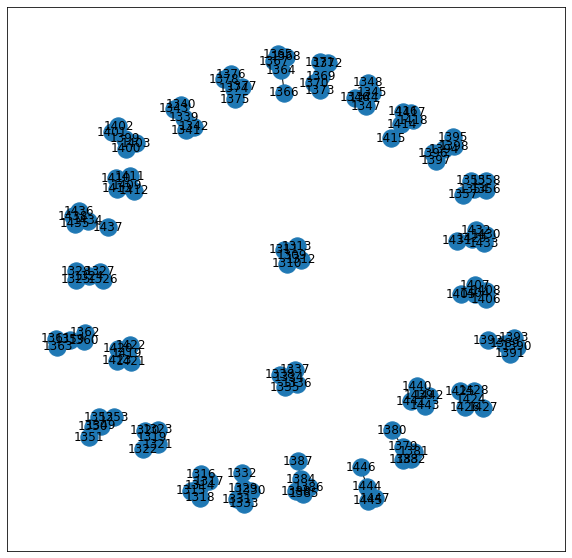

In [24]:
D = G.subgraph(list(range(1512))[1309:1448]) 
print(nx.number_connected_components(D))
D1 = G.subgraph(list(range(1512))[1309:1319]) 
D2 = G.subgraph(list(range(1512))[1459:1448]) 
plt.figure(figsize=(10, 10))
nx.draw_networkx(D)
#nx.draw_networkx(D1)
#nx.draw_networkx(D2)
plt.show()

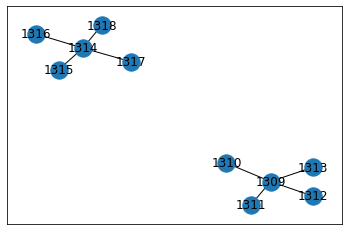

In [25]:
nx.draw_networkx(D1)

In [26]:
# +88(1) +88(3) + 176(n)

G.add_nodes_from(list(range(1512,1688)))
for i in range(22):
  G.add_edge(1310 + 5*i, 1512 + 8*i)
  G.add_edge(1310 + 5*i, 1513 + 8*i)

  G.add_edge(1311 + 5*i, 1514 + 8*i)
  G.add_edge(1311 + 5*i, 1515 + 8*i)

  G.add_edge(1312 + 5*i, 1516 + 8*i)
  G.add_edge(1312 + 5*i, 1517 + 8*i)

  G.add_edge(1313 + 5*i, 1518 + 8*i)
  G.add_edge(1313 + 5*i, 1519 + 8*i)

get_graph_stats(G)

{'number_nodes': 1688,
 'number_cc': 168,
 'radius': 15,
 'diameter': 28,
 'average_clustering': 0.0,
 'average_path_length': 11.743697478991596}

In [27]:
print_degree_distribution(G, degree_sequence)

1: 1328, target=1299, diff=-29
2: 86, target=304, diff=218
3: 102, target=107, diff=5
4: 55, target=55, diff=0
5: 26, target=26, diff=0
6: 26, target=26, diff=0
7: 13, target=13, diff=0
8: 10, target=10, diff=0
9: 6, target=6, diff=0
10: 7, target=7, diff=0
11: 8, target=8, diff=0
12: 1, target=1, diff=0
13: 6, target=6, diff=0
14: 2, target=2, diff=0
15: 3, target=3, diff=0
16: 1, target=1, diff=0
17: 2, target=2, diff=0
19: 2, target=2, diff=0
21: 2, target=2, diff=0
24: 1, target=1, diff=0
46: 1, target=1, diff=0

1688, target=1882, diff=194


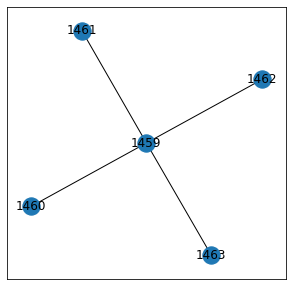

In [28]:
D = G.subgraph(list(range(1512))[1459:1464]) 
plt.figure(figsize=(5, 5))
nx.draw_networkx(D)
plt.show()

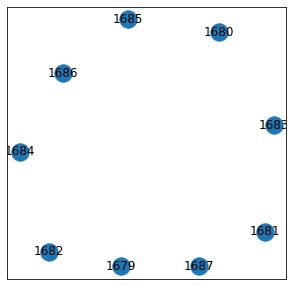

In [29]:
D = G.subgraph(list(range(1689))[1679:]) 
plt.figure(figsize=(5, 5))
nx.draw_networkx(D)
plt.show()

In [30]:
# +1(3) +1(1) +8(2) +10(n)

G.add_nodes_from(list(range(1688,1698)))

G.add_edges_from([(1460, 1688), (1460, 1690), (1688, 1689), (1690, 1691), (1461, 1692), (1692, 1693),
                  (1462, 1694), (1694, 1695), (1463, 1696), (1696, 1697)])

get_graph_stats(G)

{'number_nodes': 1698,
 'number_cc': 168,
 'radius': 15,
 'diameter': 28,
 'average_clustering': 0.0,
 'average_path_length': 11.743697478991596}

In [31]:
print_degree_distribution(G, degree_sequence)

1: 1329, target=1299, diff=-30
2: 94, target=304, diff=210
3: 103, target=107, diff=4
4: 55, target=55, diff=0
5: 26, target=26, diff=0
6: 26, target=26, diff=0
7: 13, target=13, diff=0
8: 10, target=10, diff=0
9: 6, target=6, diff=0
10: 7, target=7, diff=0
11: 8, target=8, diff=0
12: 1, target=1, diff=0
13: 6, target=6, diff=0
14: 2, target=2, diff=0
15: 3, target=3, diff=0
16: 1, target=1, diff=0
17: 2, target=2, diff=0
19: 2, target=2, diff=0
21: 2, target=2, diff=0
24: 1, target=1, diff=0
46: 1, target=1, diff=0

1698, target=1882, diff=184


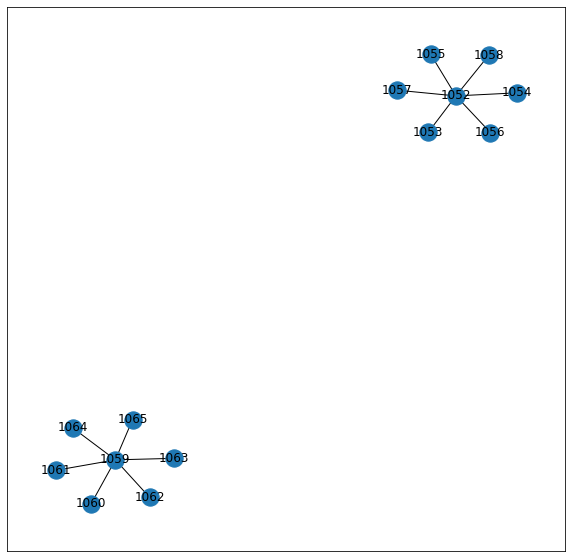

In [32]:
D = G.subgraph(list(range(1698))[1052:1157]) 
D1 = G.subgraph(list(range(1698))[1052:1066]) 
plt.figure(figsize=(10, 10))
nx.draw_networkx(D1)
plt.show()

In [33]:
G.add_nodes_from(list(range(1698,1878)))
for i in range(15):
  G.add_edges_from([(1053 + 7*i, 1698 + 12*i), (1698 + 12*i, 1704 + 12*i),
                    (1054 + 7*i, 1699 + 12*i), (1699 + 12*i, 1705 + 12*i),
                    (1055 + 7*i, 1700 + 12*i), (1700 + 12*i, 1706 + 12*i),
                    (1056 + 7*i, 1701 + 12*i), (1701 + 12*i, 1707 + 12*i),
                    (1057 + 7*i, 1702 + 12*i), (1702 + 12*i, 1708 + 12*i),
                    (1058 + 7*i, 1703 + 12*i), (1703 + 12*i, 1709 + 12*i),])
  if i < 11:
    G.add_edge(1704 + 12*i, 1705 + 12*i)
get_graph_stats(G)

{'number_nodes': 1878,
 'number_cc': 168,
 'radius': 15,
 'diameter': 28,
 'average_clustering': 0.0,
 'average_path_length': 11.743697478991596}

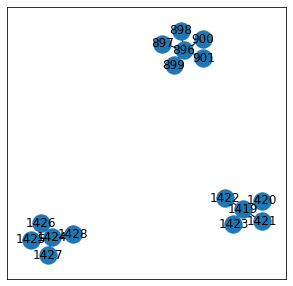

In [34]:
nodes = [1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,896,897,898,899,900,901]
D = G.subgraph(nodes) 
plt.figure(figsize=(5, 5))
nx.draw_networkx(D)
plt.show()

In [35]:
# +4(3)
#G.add_nodes_from(list(range(1878,1882)))
#G.add_edges_from([(1425,1426),(1427,1428),(1425,1878),(1426,1879),(1427,1880),(1428,1881)])
#get_graph_stats(G)

In [36]:
# +4(3)
G.add_nodes_from(list(range(1878,1882)))
G.add_edges_from([(897,898),(899,900),(897,1878),(898,1879),(899,1880),(900,1881)])
get_graph_stats(G)

{'number_nodes': 1882,
 'number_cc': 168,
 'radius': 15,
 'diameter': 28,
 'average_clustering': 0.0008147360963513991,
 'average_path_length': 11.743697478991596}

In [37]:
# +4(3)
#G.add_nodes_from(list(range(1878,1882)))
#G.add_edges_from([(1878, 1879), (1878, 1880), (1878, 1881), (1879, 1880), (1879, 1881), (1880, 1881)])
#get_graph_stats(G)

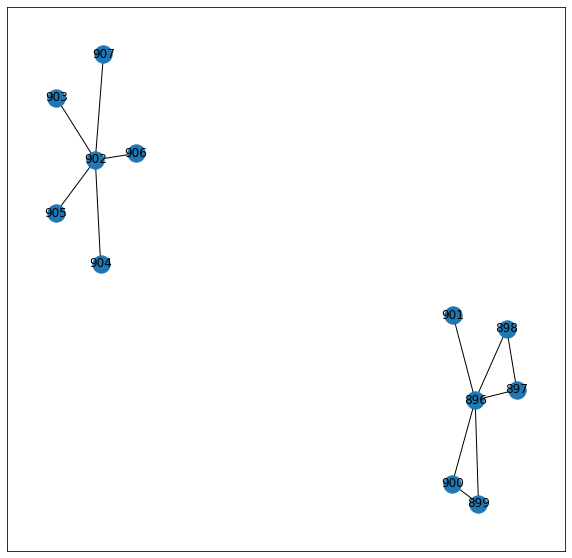

In [38]:
D = G.subgraph(list(range(1878))[896:1052]) 
D1 = G.subgraph(list(range(1878))[896:908]) 
plt.figure(figsize=(10, 10))
nx.draw_networkx(D1)
plt.show()

In [39]:
#G.add_edge(897, 903)
#get_graph_stats(G)

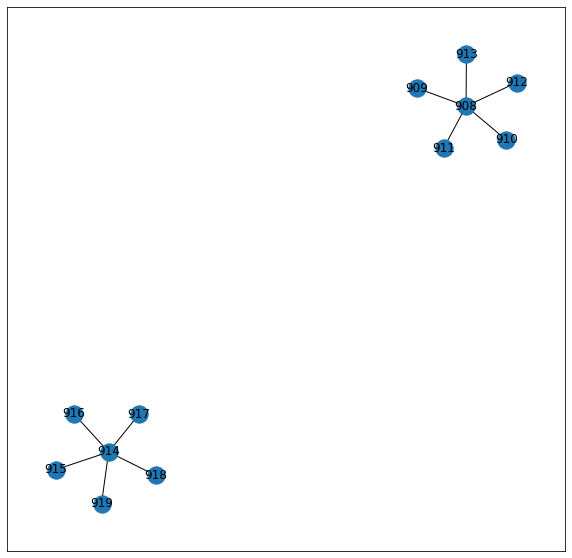

In [40]:
D = G.subgraph(list(range(1882))[896:1052]) 
D1 = G.subgraph(list(range(1882))[908:920]) 
plt.figure(figsize=(10, 10))
nx.draw_networkx(D1)
plt.show()

In [41]:
# +ac with 5-star
#for i in range(2):
#  G.add_edge(909 + 6*i, 910 + 6*i)
#  G.add_edge(911 + 6*i, 912 + 6*i)
#get_graph_stats(G)

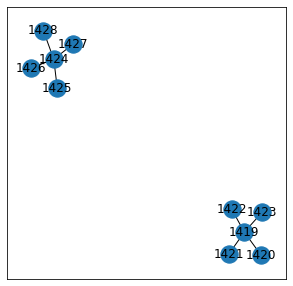

In [42]:
nodes = [1419,1420,1421,1422,1423,1424,1425,1426,1427,1428]
D = G.subgraph(nodes) 
plt.figure(figsize=(5, 5))
nx.draw_networkx(D)
plt.show()

In [43]:
# +ac with 4-star
#for i in range(1):
#  G.add_edge(1420 + 5*i, 1421 + 5*i)
#get_graph_stats(G)

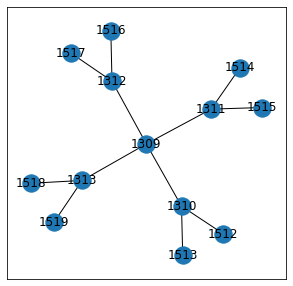

In [44]:
nodes = [1309,1310,1311,1312,1313,1512,1513,1514,1515,1516,1517,1518,1519]
D = G.subgraph(nodes) 
plt.figure(figsize=(5, 5))
nx.draw_networkx(D)
plt.show()

In [45]:
# +ac with3-degree
#G.add_edge(1512,1513)
#G.add_edge(1514,1515)
#G.add_edge(1516,1517)
#get_graph_stats(G)

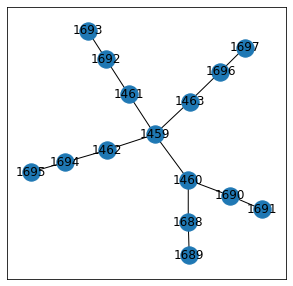

In [46]:
nodes = [1459,1460,1461,1462,1463,1688,1689,1690,1691,1692,1693,1694,1695,1696,1697]
D = G.subgraph(nodes) 
plt.figure(figsize=(5, 5))
nx.draw_networkx(D)
plt.show()

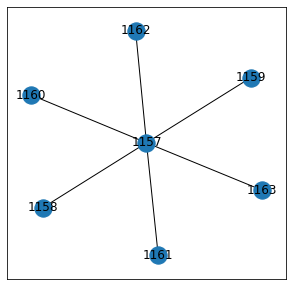

In [47]:
nodes = [1157,1158,1159,1160,1161,1162, 1163]
#nodes = list(range(1882))[1157:1178]
D = G.subgraph(nodes) 
plt.figure(figsize=(5, 5))
nx.draw_networkx(D)
plt.show()

In [48]:
#G.add_edge(1158,1160)
#G.add_edge(1159,1163)
#G.add_edge(1161,1162)
#get_graph_stats(G)

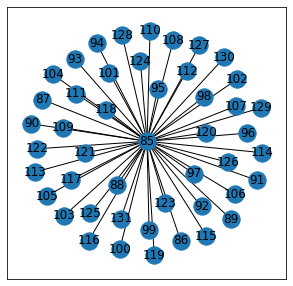

In [49]:
#nodes = [1157,1158,1159,1160,1161,1162, 1163]
nodes = list(range(1882))[85:132]
D = G.subgraph(nodes) 
plt.figure(figsize=(5, 5))
nx.draw_networkx(D)
plt.show()

In [50]:
G.add_edge(86,87)
G.add_edge(89,90)
G.add_edge(92,93)
G.add_edge(96,97)
get_graph_stats(G)

{'number_nodes': 1882,
 'number_cc': 168,
 'radius': 15,
 'diameter': 28,
 'average_clustering': 0.005067586645926064,
 'average_path_length': 11.743697478991596}

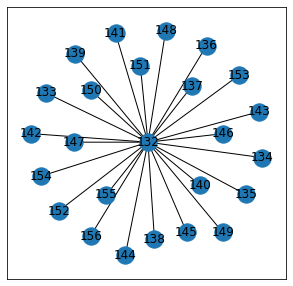

In [51]:
nodes = list(range(1882))[132:157]
D = G.subgraph(nodes) 
plt.figure(figsize=(5, 5))
nx.draw_networkx(D)
plt.show()

In [52]:
#G.add_edge(133,134)
#get_graph_stats(G)

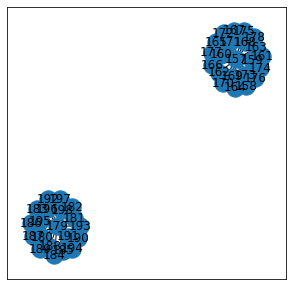

In [53]:
nodes = list(range(1882))[157:199]
D = G.subgraph(nodes) 
plt.figure(figsize=(5, 5))
nx.draw_networkx(D)
plt.show()

In [54]:
#G.add_edge(158,159)
#G.add_edge(181,182)
#get_graph_stats(G)

In [55]:
print_degree_distribution(G, degree_sequence)

1: 1299, target=1299, diff=0
2: 304, target=304, diff=0
3: 107, target=107, diff=0
4: 55, target=55, diff=0
5: 26, target=26, diff=0
6: 26, target=26, diff=0
7: 13, target=13, diff=0
8: 10, target=10, diff=0
9: 6, target=6, diff=0
10: 7, target=7, diff=0
11: 8, target=8, diff=0
12: 1, target=1, diff=0
13: 6, target=6, diff=0
14: 2, target=2, diff=0
15: 3, target=3, diff=0
16: 1, target=1, diff=0
17: 2, target=2, diff=0
19: 2, target=2, diff=0
21: 2, target=2, diff=0
24: 1, target=1, diff=0
46: 1, target=1, diff=0

1882, target=1882, diff=0


In [56]:
get_graph_stats(G)

{'number_nodes': 1882,
 'number_cc': 168,
 'radius': 15,
 'diameter': 28,
 'average_clustering': 0.005067586645926064,
 'average_path_length': 11.743697478991596}

In [57]:
part_score = get_part_score(G, number_cc_value, number_cc_sigma, radius_value, radius_sigma, diameter_value, diameter_sigma,
                   average_clustering_value, average_clustering_sigma, average_path_length_value, average_path_length_sigma)
score = get_score(G, part_score, degrees)
score

number_cc_score=100.0
radius_score=100.0
diameter_score=100.0
average_clustering_score=99.99996892072727
average_path_length_score=99.99972230521868
ks=100.0


99.99994853765766

In [58]:
print('TARGET:')
print(f'number_nodes: value:\n{number_nodes}')
print(f'number_cc: value, sigma:\n{number_cc_value, number_cc_sigma}')
print(f'radius: value, sigma:\n{radius_value, radius_sigma}')
print(f'diameter: value, sigma:\n{diameter_value, diameter_sigma}')
print(f'average_clustering: value, sigma:\n{average_clustering_value, average_clustering_sigma}')
print(f'average_path_length: value, sigma:\n{average_path_length_value, average_path_length_sigma}')

TARGET:
number_nodes: value:
1882
number_cc: value, sigma:
(168, 32)
radius: value, sigma:
(15, 2)
diameter: value, sigma:
(28, 4)
average_clustering: value, sigma:
(0.005066798238955518, 0.001)
average_path_length: value, sigma:
(11.748410823170731, 2)


In [59]:
with open('competititon_1_submission_12.txt', mode='w') as f1:
  result = ''
  for edge in sorted(G.edges):
    u, v = edge
    result += f'{u} {v}'
    result += '\n'
  f1.write(result)

In [60]:
with open('competititon_1_submission_12.txt', mode='r') as f1:
  s = f1.read()
print(s[:100])

0 1
0 29
0 30
0 58
1 2
2 3
3 4
4 5
4 35
5 6
6 7
7 8
8 9
8 59
9 10
10 11
11 12
12 13
13 14
14 15
15 1


In [61]:
G.number_of_nodes()

1882

In [62]:
G.number_of_edges()

1740